# Text Classification: Multi Class

> **Disclaimer ⚠️:**
> - Demo ini sebatas referensi saja
> - Tidak boleh asal copy paste terutama pada bagian dengan tanda **[Additional ⚠️]** karna berpotensi terkena **PLAGIARISM**.

> Referensi Utama: https://www.dicoding.com/academies/185/tutorials/10144  
> Referensi Tambahan:
  - https://github.com/reevald/Oh-Dance-AI/blob/main/oh-dance-nlp-v0.ipynb

## Kriteri dan Penilaian

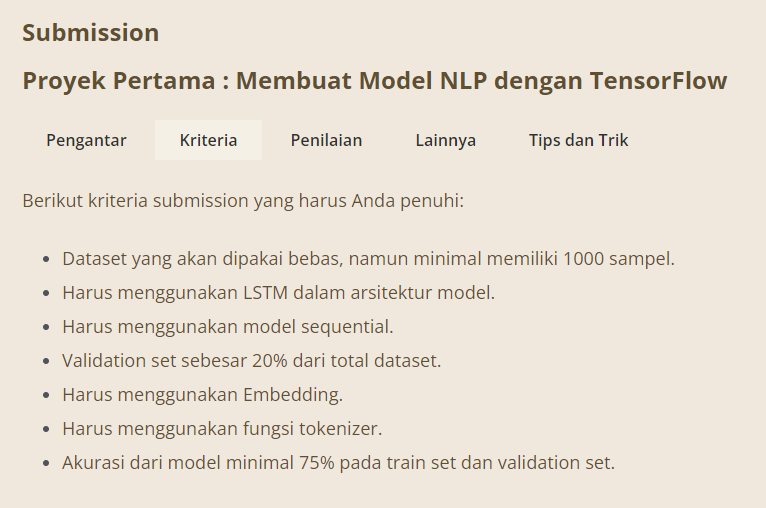

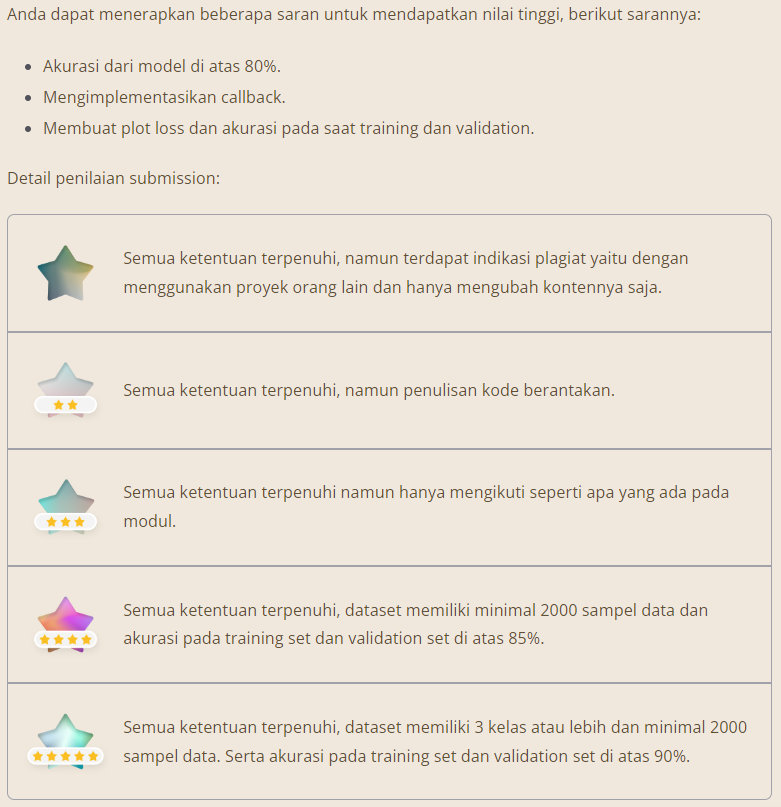

## Importing Required Libraries

In [ ]:
# Untuk pengolahan data
import numpy as np
import pandas as pd
import re
import nltk
import string
import tensorflow as tf
from nltk.corpus import stopwords
from collections import defaultdict
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Untuk visualisasi
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Persiapan menggunakan stopwords versi Bahasa Indonesia

In [ ]:
nltk.download('stopwords')
stopwords_id = set(stopwords.words('indonesian'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Download Dataset

- Download: https://www.kaggle.com/antoniuscs/imdb-synopsis-indonesian-movies
- Kemudian upload ke Google Colab

## Load Data

In [ ]:
df = pd.read_csv('imdb_indonesian_movies_2.csv')
df = df.drop(columns=['judul_film'])
df.head()

,ringkasan_sinopsis,genre
0,Raden Mas Said putra sulung Tumenggung Wilarik...,Drama
1,Soe Hok Gie adalah seorang aktivis yang hidup ...,Drama
2,Guru Bangsa Tjokroaminoto menceritakan tentang...,Drama
3,POL menceritakan kisah hidup yang luar biasa d...,Drama
4,Perjalanan pahlawan Indonesia KH Ahmad Dahlan ...,Drama


## **[Additional ⚠️]** Explore the Data

Tujuan dari explore data adalah untuk mendapatkan gambaran / insight dari data yang digunakan. Mulai dari distribusi data, korelasi antar fitur (kolom) pada data, hingga suatu hal baru yang bisa dimanfaatkan untuk improvement performa model nantinya.

### Basic Explore

#### Check Data Type

In [ ]:
df.describe()

,ringkasan_sinopsis,genre
count,1005,1005
unique,1001,5
top,Lasmini (Murti Sari Dewi) yang diperkosa dan d...,Drama
freq,2,202


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ringkasan_sinopsis  1005 non-null   object
 1   genre               1005 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


Dari data

#### Check Null / NaN value

In [ ]:
# Cek dahulu apakah ada data yang null apa tidak
df.isna().sum()

ringkasan_sinopsis    0
genre                 0
dtype: int64

Jika tidak ada yang null, maka bisa lanjut ke tahap pengecekan selanjutnya. Namun, jika terdapat baris yang null atau NaN, maka kita punya dua pilihan: antara menghapusnya atau mengisinya dengan nilai default. Pada demo ini kita pilih menghapus data null tersebut.

In [ ]:
# Hapus baris dengan nilai null atau NaN
df = df.dropna(how='any',axis=0)
# Kita cek kembali
df.isna().sum()

ringkasan_sinopsis    0
genre                 0
dtype: int64

#### Class Distribution

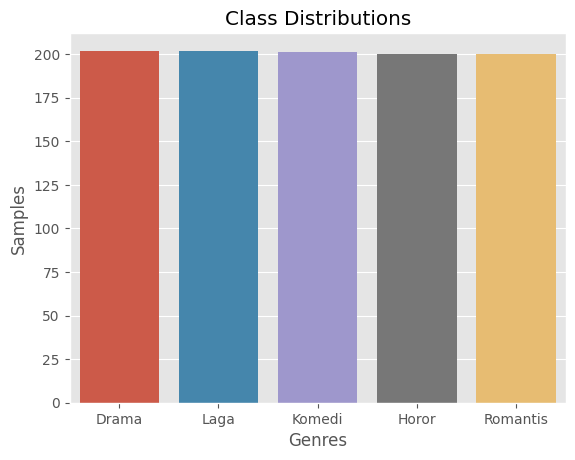

In [ ]:
x = df.genre.value_counts()
sns.barplot(x=x.index, y=x)
plt.gca().set_title('Class Distributions')
plt.gca().set_ylabel('Samples')
plt.gca().set_xlabel('Genres')
plt.show()

Terlihat bahwa distribusi class (genre) seimbang untuk semua kelas. Jika terjadi ketidak seimbangan yang signifikan semisal kelas A sebanyak 1000 data sedangkan kelas B hanya 100 data, maka perlu dilakukan upsampling atau downsampling.

Alternatif lain jika mengalami unbalance dan datanya sulit / tidak boleh untuk di resampling (up/down) maka kita bisa memilih metrics dan batas prediksi yang adil. Contoh ketika ada dua kelas A (1000 data) dan B (1000 data). Maka kita bisa menggunakan metrics F1 Score Macro (cocok untuk unbalance data) dan batas prediksi yang sesuai. Contoh hasil prediksi menunjukan probabilitas 0.6 (jika mengarah ke 1 maka prediksinya kelas A dan jika mengarah ke 0 maka prediksinya kelas B). Jika kita menggunakan batas prediksinya 0.5 (pertengahan 0 dan 1) maka itu belum tentu adil mengingat sample data kelas A jauh lebih banyak. Sehingga kita perlu menguji batas prediksi yang adil.

### Deep Explore

#### Cek Number of Characters in Sinopsis

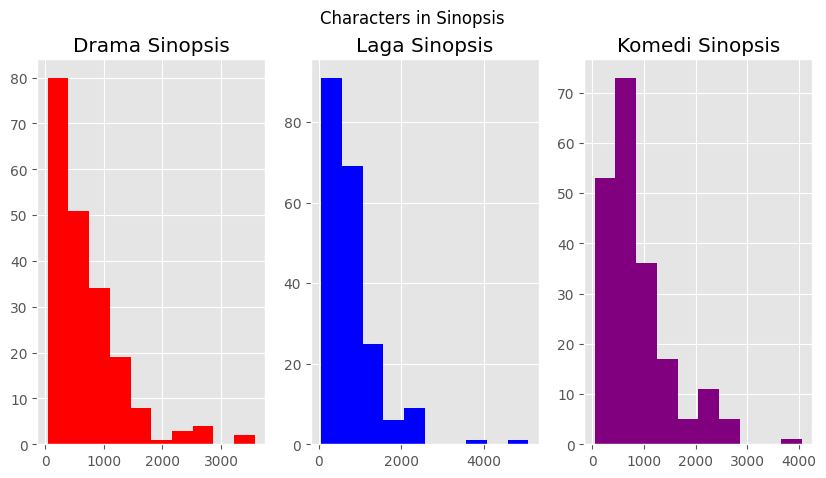

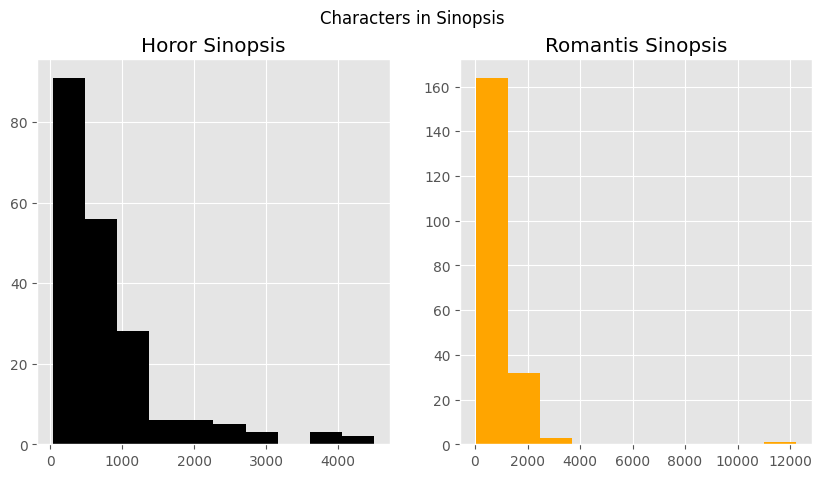

In [ ]:
fig1, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
count_drama = df[df['genre']=='Drama']['ringkasan_sinopsis'].str.len()
ax1.hist(count_drama, color='red')
ax1.set_title('Drama Sinopsis')

count_laga = df[df['genre']=='Laga']['ringkasan_sinopsis'].str.len()
ax2.hist(count_laga, color='blue')
ax2.set_title('Laga Sinopsis')

count_komedi = df[df['genre']=='Komedi']['ringkasan_sinopsis'].str.len()
ax3.hist(count_komedi, color='purple')
ax3.set_title('Komedi Sinopsis')
fig1.suptitle('Characters in Sinopsis')

fig2, (ax4, ax5) = plt.subplots(1, 2, figsize=(10, 5))
count_horor = df[df['genre']=='Horor']['ringkasan_sinopsis'].str.len()
ax4.hist(count_horor, color='black')
ax4.set_title('Horor Sinopsis')

count_romantis = df[df['genre']=='Romantis']['ringkasan_sinopsis'].str.len()
ax5.hist(count_romantis, color='orange')
ax5.set_title('Romantis Sinopsis')
fig2.suptitle('Characters in Sinopsis')

plt.show()

Terlihat untuk sinopsis di semua genre memiliki rata-rata 0 - 1000 karakter. Beberapa sinopsis mempunyai 4000 kalimat bahkan pada genre Romantis terdapat sinopsis dengan 10000 karakter.



#### Number of words in Sinopsis

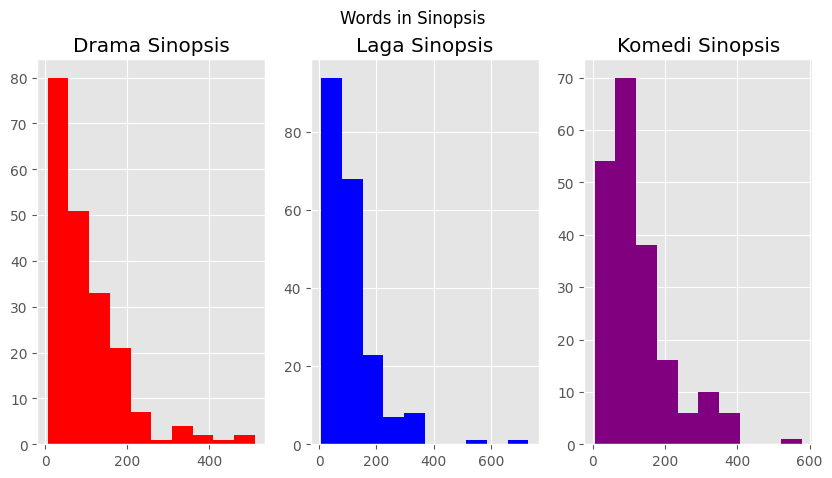

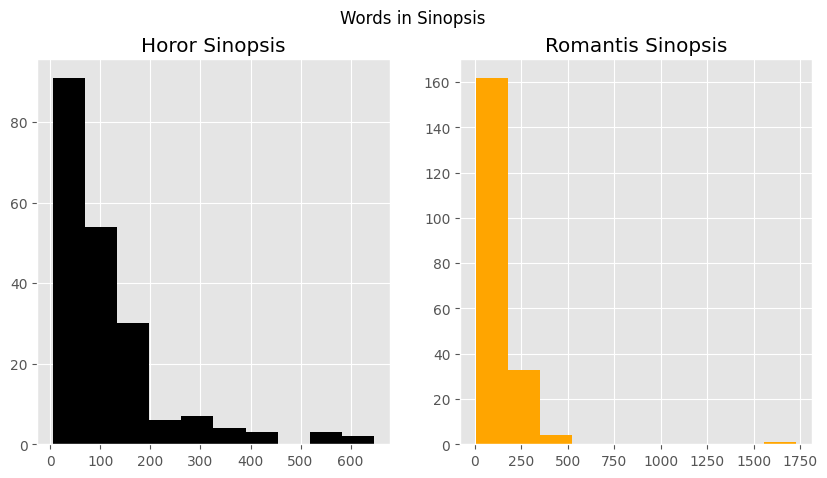

In [ ]:
fig1, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
count_drama = df[df['genre']=='Drama']['ringkasan_sinopsis'].str.split().map(lambda x: len(x))
ax1.hist(count_drama, color='red')
ax1.set_title('Drama Sinopsis')

count_laga = df[df['genre']=='Laga']['ringkasan_sinopsis'].str.split().map(lambda x: len(x))
ax2.hist(count_laga, color='blue')
ax2.set_title('Laga Sinopsis')

count_komedi = df[df['genre']=='Komedi']['ringkasan_sinopsis'].str.split().map(lambda x: len(x))
ax3.hist(count_komedi, color='purple')
ax3.set_title('Komedi Sinopsis')
fig1.suptitle('Words in Sinopsis')

fig2, (ax4, ax5) = plt.subplots(1, 2, figsize=(10, 5))
count_horor = df[df['genre']=='Horor']['ringkasan_sinopsis'].str.split().map(lambda x: len(x))
ax4.hist(count_horor, color='black')
ax4.set_title('Horor Sinopsis')

count_romantsi = df[df['genre']=='Romantis']['ringkasan_sinopsis'].str.split().map(lambda x: len(x))
ax5.hist(count_romantsi, color='orange')
ax5.set_title('Romantis Sinopsis')
fig2.suptitle('Words in Sinopsis')

plt.show()

#### Common Stopwords in Sinposis

In [ ]:
def create_corpus(genre):
  corpus = []

  for list_words in df[df['genre']==genre]['ringkasan_sinopsis'].str.split():
    for word in list_words:
      corpus.append(word.lower())

  return corpus

def common_stopwords(genre):
  corpus = create_corpus(genre)

  dict_result = defaultdict(int)
  for word in corpus:
    if word in stopwords_id:
      dict_result[word] += 1

  top_result = sorted(dict_result.items(), key=lambda x : x[1], reverse=True)[:10] # Top Ten

  x, y = zip(*top_result)
  plt.bar(x, y)
  plt.title(genre)
  plt.show()

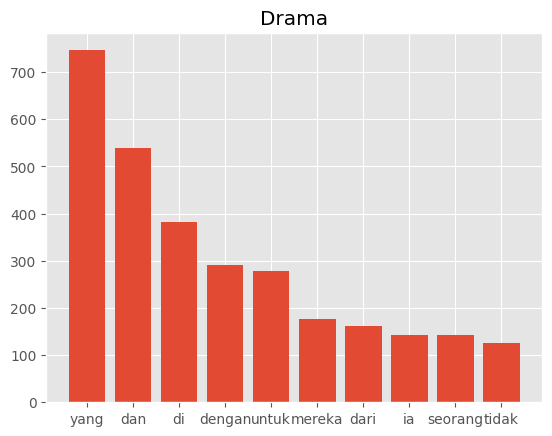

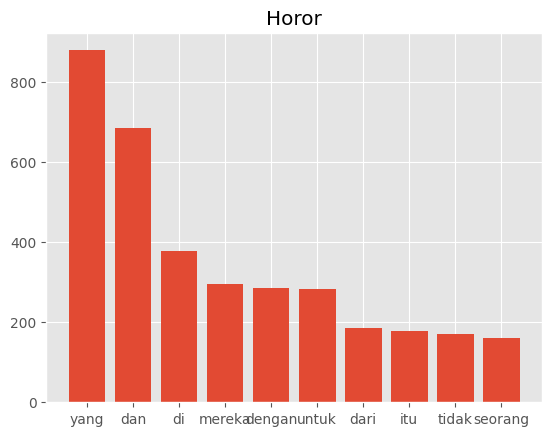

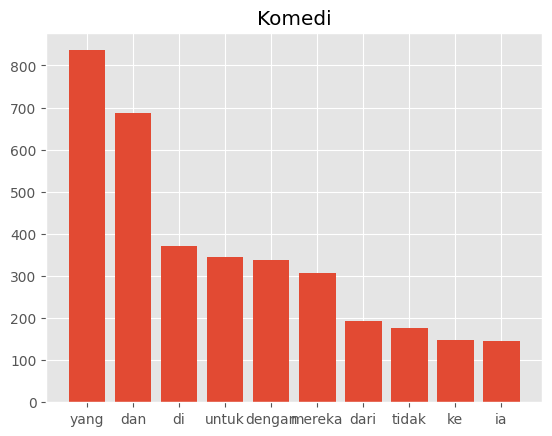

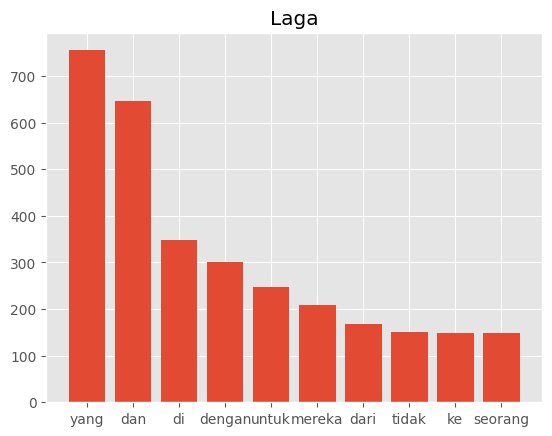

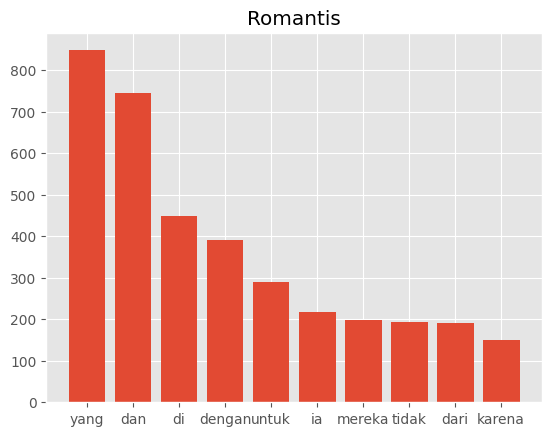

In [ ]:
for genre in df.genre.unique():
  common_stopwords(genre)

#### Analyzing Punctuations

In [ ]:
def analyze_punctuations(genre):
  corpus = create_corpus(genre)

  dict_result = defaultdict(int)

  special_char = string.punctuation

  for word in corpus:
    for char in special_char:
      if char in word:
        dict_result[char] += 1


  x, y = zip(*dict_result.items())
  plt.bar(x, y)
  plt.title(genre)
  plt.show()

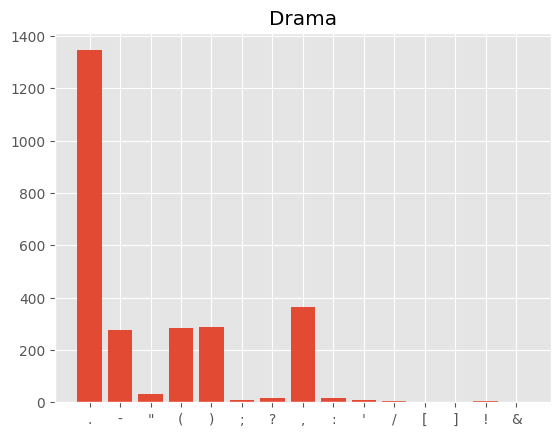

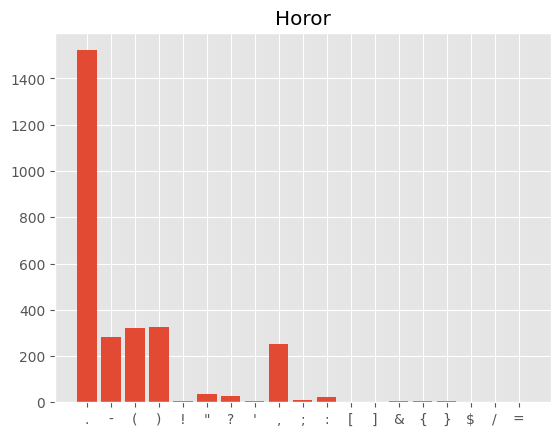

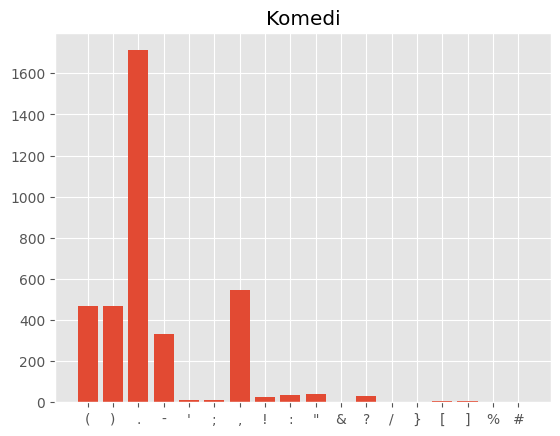

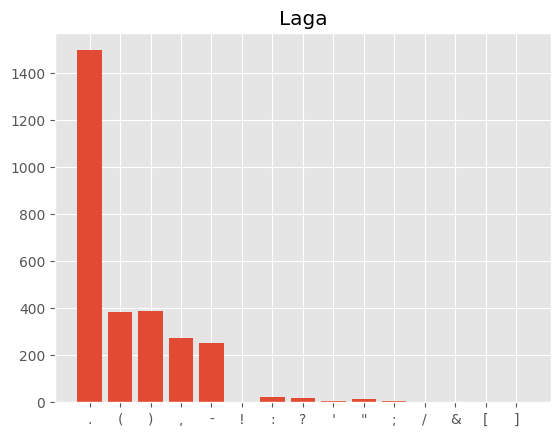

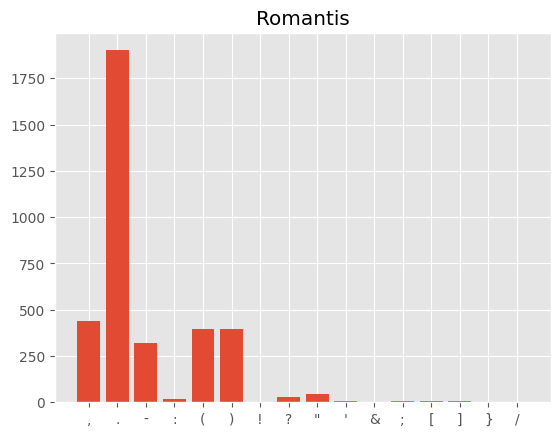

In [ ]:
for genre in df.genre.unique():
  analyze_punctuations(genre)

#### Common Words (Not in Stopwords)

In [ ]:
def common_words(label):
  corpus = create_corpus(label)
  counter = Counter(corpus)
  most = counter.most_common()

  x = []
  y = []

  for word, count in most[:40]:
    if (word not in stopwords_id):
      x.append(word)
      y.append(count)

  sns.barplot(x=y, y=x)
  plt.title(label)
  plt.show()

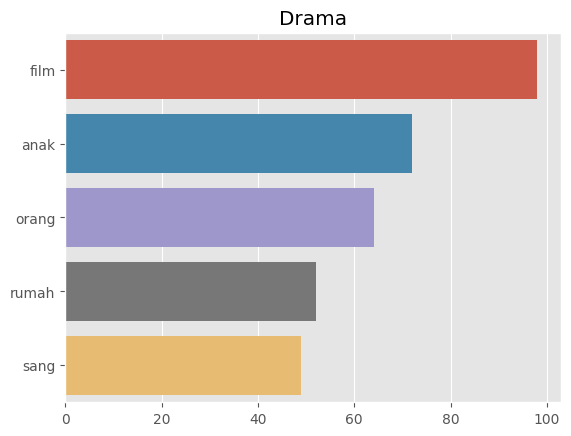

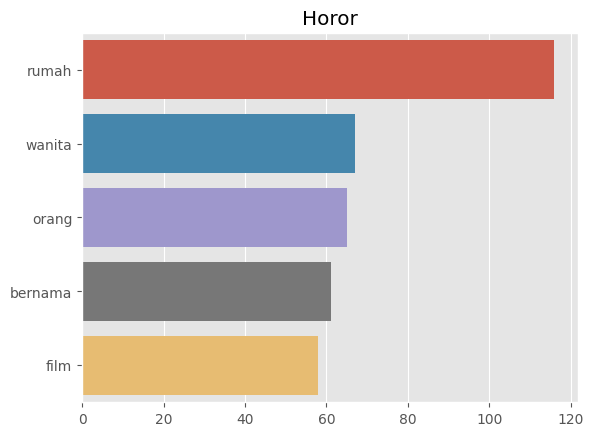

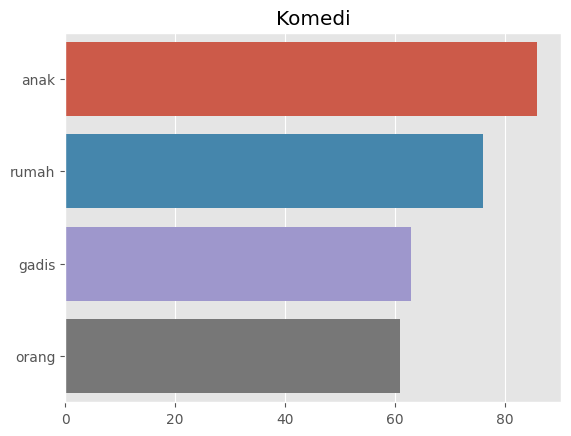

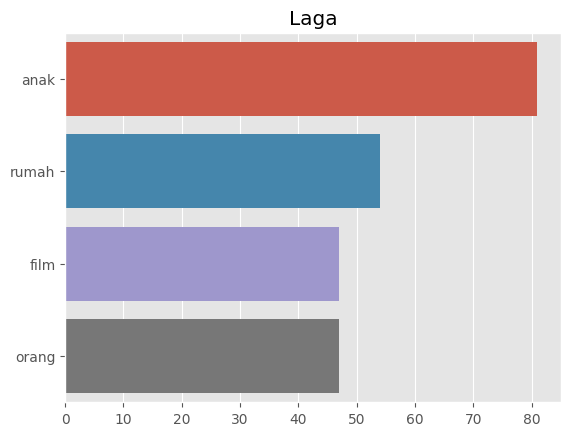

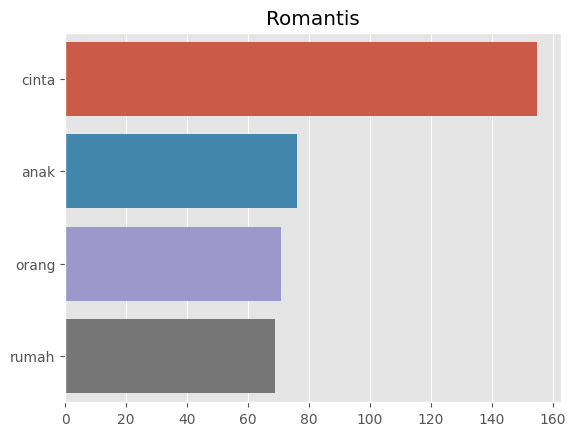

In [ ]:
for genre in df.genre.unique():
  common_words(genre)

#### Ngram analysis
Analisis n kata berurutan yang sering muncul pada sinopsis. Pada kasus ini kita analisa untuk n=2, jadi dua kata yang sering muncul.

In [ ]:
def get_top_sinopsis_bigrams(corpus, n=None):
  vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis=0)
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
  return words_freq[:n]

<Axes: >

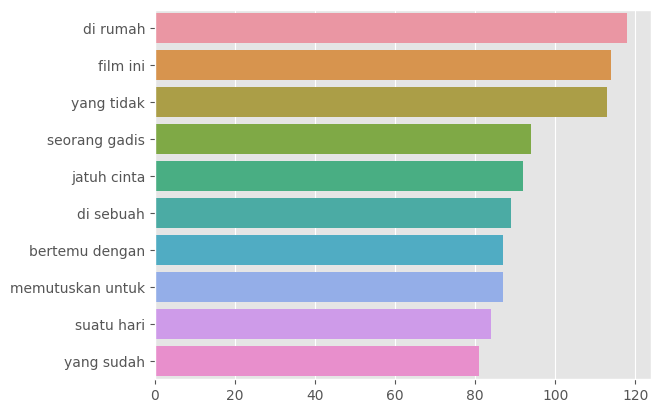

In [ ]:
top_sinopsis_bigrams = get_top_sinopsis_bigrams(df['ringkasan_sinopsis'])[:10]
x, y = map(list, zip(*top_sinopsis_bigrams))
sns.barplot(x=y, y=x)

## **[Additional ⚠️]** Data Cleaning

Catatan: tidak semua kasus cocok untuk dilakukan cleaning dengan menghilangkan url, punctuations, ataupun stopwords. Untuk mengetahuinya perlu dilakukan ujicoba sebelum dan sesudah menggunakan data cleaning dan dibandingkan performa model yang dihasilkan. Kusus untuk kasus text classification direkomendasikan untuk melakukan pembersihan stopwords (kata-kata yang kurang penting) dari data. Sehingga nantinya hanya tertinggal kata-kata penting yang memudahkan model untuk mengenali pola dari masing-masing kelas.

### Removing URLs

In [ ]:
example = "Test sentences : https://www.dicoding.com/academies/185/tutorials/10144 sample url"

def remove_url(text):
  url = re.compile(r'https?://\S+|www\.\S+')
  return url.sub(r'', text)

remove_url(example)

'Test sentences :  sample url'

In [ ]:
df['ringkasan_sinopsis'] = df['ringkasan_sinopsis'].apply(lambda x : remove_url(x))

### Removing Punctuations

In [ ]:
def remove_punct(text):
  table = str.maketrans('','',string.punctuation)
  return text.translate(table)

example = "Contoh Genre Film: 1) Drama, 2) Komedi', 3) Romantis."
print(remove_punct(example))

Contoh Genre Film 1 Drama 2 Komedi 3 Romantis


In [ ]:
df['ringkasan_sinopsis'] = df['ringkasan_sinopsis'].apply(lambda x: remove_punct(x))

### Removing stopwords

In [ ]:
def remove_stopwords(text):
  final_text = []
  for word in text.split():
    if word.strip().lower() not in stopwords_id:
      final_text.append(word.strip().lower())
  return " ".join(final_text)

example = "Genre Komedi dan Romantis adalah genre yang menarik"
print(remove_stopwords(example))

genre komedi romantis genre menarik


In [ ]:
df['ringkasan_sinopsis'] = df['ringkasan_sinopsis'].apply(lambda x: remove_stopwords(x))

## Preprocessing Data
Tahap ini berguna untuk mempersiapkan data agar sesuai dan bisa diproses oleh model nantinya.

### One Hot Encoding for Class (Genre)

Karena label kita berupa data kategorikal, maka kita perlu melakukan proses one-hot-encoding. Jalankan kode di bawah untuk melakukan one-hot-encoding dan membuat dataframe baru.

In [ ]:
category = pd.get_dummies(df.genre)
df_baru = pd.concat([df, category], axis=1)
df_baru = df_baru.drop(columns='genre')
df_baru

,ringkasan_sinopsis,Drama,Horor,Komedi,Laga,Romantis
0,raden mas said putra sulung tumenggung wilarik...,1,0,0,0,0
1,soe hok gie aktivis hidup enam puluhan terleta...,1,0,0,0,0
2,guru bangsa tjokroaminoto menceritakan lepas e...,1,0,0,0,0
3,pol menceritakan kisah hidup 3 pemain skateboa...,1,0,0,0,0
4,perjalanan pahlawan indonesia kh ahmad dahlan ...,1,0,0,0,0
...,...,...,...,...,...,...
1000,winter in tokyo berpusat kehidupan ishida keik...,0,0,0,0,1
1001,markonah melarikan jakarta dijodohkan orang tu...,0,0,0,0,1
1002,aking 36 jam last night pasangan menikah joann...,0,0,0,0,1
1003,proyek lelaki indotrinidadian india mencari ak...,0,0,0,0,1


### Split Dataset

Sebelumnya, agar dapat diproses oleh model, kita perlu mengubah nilai-nilai dari dataframe ke dalam tipe data numpy array menggunakan atribut values.

In [ ]:
sinopsis = df_baru['ringkasan_sinopsis'].values
label = df_baru[['Drama', 'Horor', 'Komedi', 'Laga', 'Romantis']].values

sinopsis_latih, sinopsis_test, label_latih, label_test = train_test_split(sinopsis, label, test_size=0.2)

### Tokenize and Padding Data

> Catatan:
> - Jangan lupa menambahkan argument `oov_token` ketika mendefinisikan tokenizer.
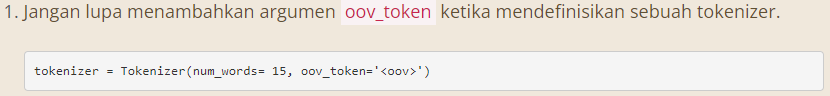
> - Ketika menggunakan `pad_sequences`, sebaiknya Anda memanfaatkan argumen lain yang tersedia seperti maxlen, truncating, dan padding.
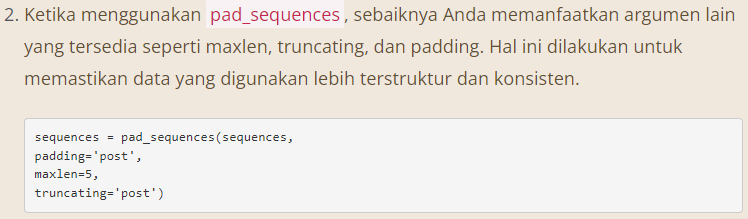
> - Proses `tokenizer.fit_on_texts()` sebaiknya hanya digunakan untuk data training saja.
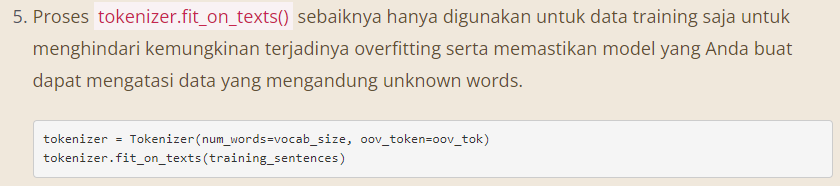

In [ ]:
tokenizer = Tokenizer(num_words=5000, oov_token='<oov>')
# Saran poin 1 (hanya fit pada data latih saja)
tokenizer.fit_on_texts(sinopsis_latih)

sekuens_latih = tokenizer.texts_to_sequences(sinopsis_latih)
sekuens_test = tokenizer.texts_to_sequences(sinopsis_test)

padded_latih = pad_sequences(
    sequences=sekuens_latih,
    # Untuk maxlen dapat diisi dengan panjang sinopsis dengan banyak kata terbanyak
    # Jika dilihat pada proses Explore Data terlihat rata-rata sinopsis mempunyai panjang
    # Sekitar 0 - 200 kata, sehingga kita dapat atur maxlen = 120
    maxlen=120,
    # Untuk padding bebas memilih "pre" atau "post"
    # Contoh:
    # sequence awal = [1,2,3]
    # padding pre (5) = [0,0,0,0,0,1,2,3]
    # padding post (5) = [1,2,3,0,0,0,0,0]
    padding='post',
    # Mengingat terdapat sinopsis yang memiliki jumlah kata lebih dari maxlen
    # Contoh ada sinopsis dengan panjang 200 kata
    # Pre: diambil kata 81-200 kata akhir dan 1-80 kata awal dibuang
    # Post: diambil kata 1-120 kata awal dan 80 kata sisanya dibuang
    truncating='post',
)
padded_test = pad_sequences(
    sequences=sekuens_test,
    maxlen=120,
    padding='post',
    truncating='post'
)

Flow:
- Misal kita punya sinopsis:
```python
sinopsis = "Layangan Putus berkisah tentang Kinan yang mantap berumah tangga dengan Aris."
```
- Tokenizer kita anggap sebagai kamus yang mentranslate kata kedalam angka. Kamus ini sudah dicocokan pada data latih sinopsis pada saat proses `fit_on_texts`. Misalkan didapat tokenizer (kamus) sebagai berikut:
```python
{
    "<oov>": 0,
    "layangan": 100,
    "putus": 6,
    "berkisah": 7,
    "tentang": 5,
    "yang": 2,
    "mantap": 4,
    "berumah": 45,
    "tangga": 56,
    "dengan": 3,
    "aris": 195,
    dst
}
```
diketahui bahwa kata `Kinan` tidak ada pada tokenizer (kamus) diatas.
- Mentranslate sinopsis menggunakan tokenizer yaitu pada saat `tokenizer.text_to_sequences`
```python
sinopsis = [100, 6, 7, 5, 0, 2, 4, 45, 56, 3, 195]
```
Untuk kata `Kinan` akan digantikan dengan <oov> (out of vocabulary).
- Setelah itu karena panjang sinopsis itu berbeda-beda, sedangkan input model mengharuskan untuk konsisten panjang sinopsisnya, maka perlu dilakukan padding (misal tipenya post dan maxlennya 15).
```python
sinopsis = [100, 6, 7, 5, 0, 2, 4, 45, 56, 3, 195, 0, 0, 0, 0]
```
- Akhirnya sinopsis tersebut sudah siap untuk diproses oleh model ^^


## Modelling

> Catatan:
> - Didalam deeplearning untuk menentukan banyak layer dan banyak unit (parameter dilayernya seperti 8, 16, dst) itu sifatnya trial and error. Tipsnya adalah memulai dengan jumlah layer dan unit yang kecil, lalu catat performa model dan lihat perubahan yang terjadi jika dilakukan perubahan banyak layer dan unit.
> - Mengimplementasikan callback.
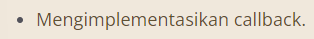
> - Jika terjadi overfitting, Anda dapat menambahkan Dropout layer untuk menanganinya.
 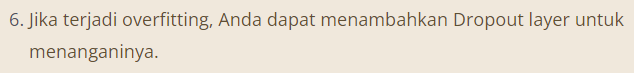

In [ ]:
model = tf.keras.Sequential([
    # Layer Embedding hingga LSTM merupakan layer untuk mengekstrak pola pada data
    tf.keras.layers.Embedding(input_dim=5000, output_dim=16),
    tf.keras.layers.LSTM(64),
    # Layer Dense untuk mengklasifikasikan hasil ekstraksi pola
    # Pada tahap ini dapat ditambahkan layer dropout untuk mengantisipasi overfitting
    tf.keras.layers.Dense(128, activation='relu'),
    # Layer dropout dapat ditambahkan pada sela" dense layer
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    # Nilai pada dropout layer dapat disesuaikan dengan trial error
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [ ]:
# Aman digunakan, karena bersumber pada platform Dicoding
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > 0.9 and logs.get('val_accuracy') > 0.9:
      print("\nAkurasi dan Val Akurasi telah mencapai >90%!")
      self.model.stop_training = True

callback_accuracy = myCallback()

### **[Additional ✅]** Callback

#### Callback EarlyStopping
Callback ini sangat berguna untuk menghentikan proses training model, apabila model tidak mengalami improvement maka otomatis dihentikan proses trainingnya. Sehingga dapat mengefisiensikan waktu training.

In [ ]:
callback_earlystopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=3)

Callback ini aman untuk dipakai ya, bisa dicopy paste, karena bersumber pada example resmi (referensi dari keras: https://keras.io/api/callbacks/early_stopping/). Bisa coba juga untuk mengubah monitor nya menjadi "accuracy" atau "val_accuracy" atau "val_loss".

## Training Model

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
# Tips untuk trial error banyak epochs bisa dikurangin misal menjadi 10
# Jika model improvementnya cukup bagus lalu ditambah lagi banyak epochsnya
num_epochs = 30
history = model.fit(
    padded_latih,
    label_latih,
    epochs=num_epochs,
    validation_data=(padded_test, label_test),
    verbose=2,
    callbacks=[callback_accuracy, callback_earlystopping])

Epoch 1/30
26/26 - 6s - loss: 1.6111 - accuracy: 0.1853 - val_loss: 1.6098 - val_accuracy: 0.1891 - 6s/epoch - 218ms/step
Epoch 2/30
26/26 - 2s - loss: 1.6099 - accuracy: 0.1978 - val_loss: 1.6099 - val_accuracy: 0.1990 - 2s/epoch - 64ms/step
Epoch 3/30
26/26 - 1s - loss: 1.6099 - accuracy: 0.1965 - val_loss: 1.6101 - val_accuracy: 0.1940 - 1s/epoch - 53ms/step
Epoch 4/30
26/26 - 1s - loss: 1.6095 - accuracy: 0.1990 - val_loss: 1.6105 - val_accuracy: 0.1891 - 1s/epoch - 54ms/step
Epoch 5/30
26/26 - 1s - loss: 1.6089 - accuracy: 0.2102 - val_loss: 1.6108 - val_accuracy: 0.2040 - 1s/epoch - 51ms/step
Epoch 6/30
26/26 - 1s - loss: 1.6007 - accuracy: 0.2450 - val_loss: 1.6096 - val_accuracy: 0.1940 - 1s/epoch - 52ms/step
Epoch 7/30
26/26 - 1s - loss: 1.5848 - accuracy: 0.2736 - val_loss: 1.6116 - val_accuracy: 0.1891 - 1s/epoch - 52ms/step
Epoch 8/30
26/26 - 1s - loss: 1.5292 - accuracy: 0.2649 - val_loss: 1.6204 - val_accuracy: 0.2736 - 1s/epoch - 52ms/step
Epoch 9/30
26/26 - 2s - loss: 1

Pada hasil training diatas terlihat accuracy dan val accuracinya masih dibawah 50% atau 0.5, dan sebelum sampai epoch 30 sudah berhenti karena tidak mengalami improvement yang signifikan.

Mari kita bandingkan hasil yang diperoleh dari Dicoding:
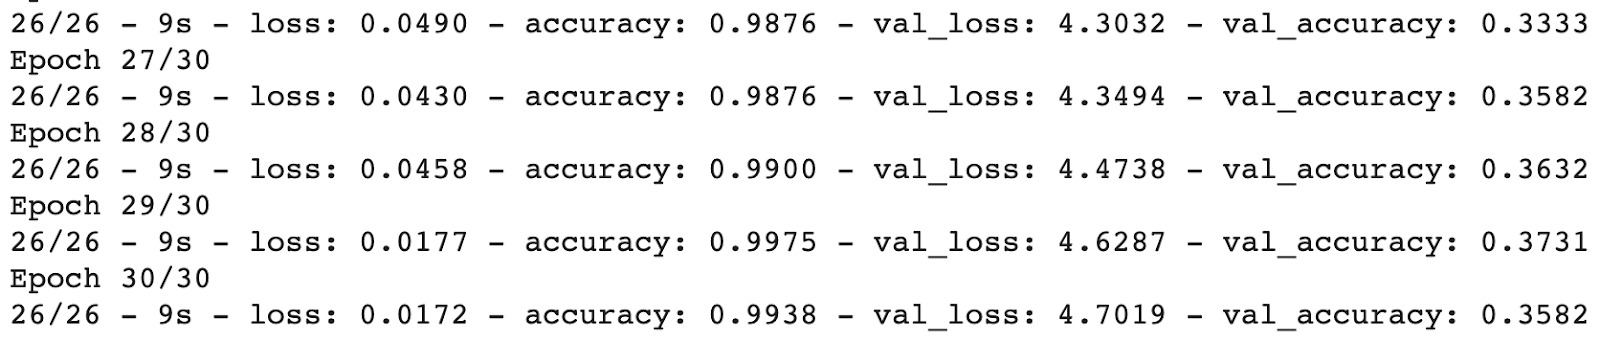

Tampak bahwa hasil dari Dicoding overfitting dan val_accuracy menunjukkan performa dibawah 0.5. Artinya apa yang kita lakukan sudah dijalan yang benar karena model kita meskipun masih memiliki akurasi kecil namun jauh tidak overfitting.

## Visualisasi Accuracy dan Loss

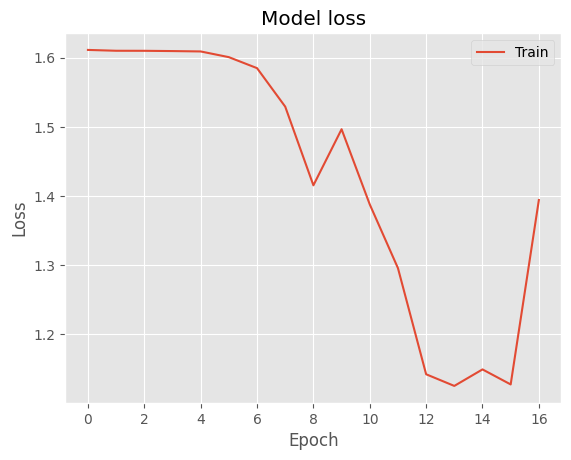

In [ ]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

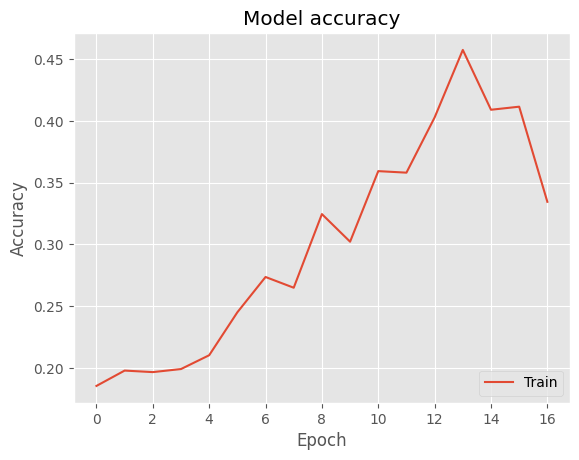

In [ ]:
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower right')
plt.show()

## Catatan Terkait Performa Model:
Ada istilah garbage in garbage out, dimana performa model sejatinya dipengaruhi oleh kualitas data. Selain itu ada faktor nilai hyperparameter model (batch size, banyak layer, banyak unit pada layer, learning rate, optimizer, dsb). Namun tetap kualitas data yang paling berpengaruh.
- Data di Industri atau yang real itu mayoritas masih kasar / berantakan, beberapa tidak lengkap, kurang terstruktur, unbalance, miss label dan lainnya. Sehingga perlu dilakukan preprocessing yang mendalam, dan jelas akan memakan waktu yang cukup lama, terlebih jika kita baru pertama kali coba.
- Jika kalian mengincar nilai akurasi dan validasi akurasi yang tinggi misal > 90 % untuk mencapai ⭐ 5, maka disarankan untuk mengambil data yang digunakan untuk akademik dan sudah terstruktur bahkan biasanya sudah dibersihkan juga. Bisa dicari di kaggle, huggingface atau https://archive.ics.uci.edu/ atau daftar referensi dataset berikut: https://docs.google.com/spreadsheets/d/1O2_7CjMnoeiG5-48sxALkAiRrMwt14JKbL47eztqQXA/edit?usp=sharing.
- Jangan memaksakan untuk terus melakukan tuning hyperparameter jika performanya masih jauh dari harapan, contoh tadi performanya dapat akurasi dan val akurasi dibawah 0.5 dan itu masih jauh dari harapan (0.9). Ada indikasi variasi datanya kurang, dan datanya yang sebenarnya perlu diimprove, seperti ditambahkan lagi banyak datanya. Dan itu diluar tugas kita. Jadi disarankan untuk mengganti dataset jika menemui kasus seperti itu.

## Feel free untuk tanya / diskusi melalui grup atau japri fasil (Kak Galang) via WA ya 🙌